In [1]:
import pandas as pd
import csv
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("Root_Insurance_data.csv",delimiter = ",")

In [3]:
## Input: Data Frame (in the format of "Root_Insurance_data.csv") and encode_rank (default = False)
## Output: Data Frame (processed by one hot encoding ready to be used to make models)

## This function will one hot encode the following columns in the data frame: 
## Currently Insured, Marital Status, click, rank (optional, determined by encode_rank = True)
## and will drop the respective columns associated to the respective values of above columns:
## unknown, S, False, 5.0 (if encode_rank = True)

import category_encoders as ce

def prepare_data(data:pd.DataFrame(), encode_rank = False, drop_column = False) -> pd.DataFrame():
    temp = data.copy()
    
    if encode_rank:
        one_hot_cols = ["Currently Insured", "Marital Status", "click", "rank"]
        drop_cols = ["Currently Insured_unknown", "Marital Status_S", "rank_5.0", "click_False"]
        column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles',
                        'Number of Drivers', 'Marital Status_M', 'bid', 'rank_1.0',
                        'rank_2.0', 'rank_3.0', 'rank_4.0', 'click_True', 'policies_sold']
    else:
        one_hot_cols = ["Currently Insured", "Marital Status", "click"]
        drop_cols = ["Currently Insured_unknown", "Marital Status_S", "click_False"]
        column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                        'Marital Status_M', 'bid', 'rank', 'click_True', 'policies_sold']
    
    encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
    temp = encoder.fit_transform(temp)
    temp = temp.drop(columns = drop_cols)
    temp = temp.reindex(columns=column_names)
    return temp

In [4]:
df = prepare_data(data)

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.metrics import average_precision_score, roc_auc_score, precision_recall_curve, accuracy_score

features = ['Currently Insured_Y',
            'Currently Insured_N',
            'Number of Vehicles',
            'bid',
            'rank']
predictor_var = "click_True"

df_train, df_test = train_test_split(df,
                                     shuffle=True,
                                     random_state=12345,
                                     test_size=.2,
                                     stratify=df[predictor_var])

In [6]:
def resample_data(df:pd.DataFrame(), resample_type = "None") -> pd.DataFrame():
    df_minority = df[df[predictor_var] == 1]
    df_majority = df[df[predictor_var] != 1]
    if resample_type == "Up":
        df_minority_up = resample(df_minority,
                                  random_state=886,
                                  n_samples=len(df_majority),
                                  replace=True)
        df_resampled = pd.concat([df_minority_up, df_majority]).sample(frac=1, random_state = 0)
    elif resample_type == "Down":
        df_majority_down = resample(df_majority,
                                    random_state=886,
                                    n_samples=len(df_minority),
                                    replace=True)
        df_resampled = pd.concat([df_majority_down, df_minority]).sample(frac=1, random_state = 0)
    elif resample_type == "Balanced":
        df_majority_bal = resample(df_majority,
                                           random_state=886,
                                           n_samples= int(len(df)/2),
                                           replace=True)
        df_minority_bal = resample(df_minority,
                                               random_state=886,
                                               n_samples=int(len(df)/2),
                                               replace=True)
        df_resampled = pd.concat([df_majority_bal, df_minority_bal]).sample(frac=1, random_state = 0) 
    else:
        df_resampled = df
    return df_resampled

In [7]:
import keras
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
import keras.backend as K
from sklearn.utils import resample,shuffle
from keras.utils.np_utils import to_categorical


avg_precision_cross_val = 0
roc_auc_cross_val = 0
accuracy_cross_val = 0


df_train_resampled = resample_data(df_train, resample_type = "None")

model = models.Sequential()
model.add(layers.Dense(len(features), activation='relu', input_dim= len(features)))
model.add(layers.Dense(len(features), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(curve = 'PR', name = 'AUCPR'), 
                       keras.metrics.AUC(name = 'AUCROC'),
                       keras.metrics.BinaryAccuracy()])


history = model.fit(df_train_resampled[features], 
                df_train_resampled[predictor_var],
                epochs = 200,
                batch_size = 1024)

y_proba = model.predict(df_test[features])
y_pred = [int(x > .5) for x in y_proba]

avg_precision_cross_val = average_precision_score(df_test[predictor_var], y_proba)
roc_auc_cross_val = roc_auc_score(df_test[predictor_var], y_proba)
accuracy_cross_val = accuracy_score(df_test[predictor_var], y_pred)

Epoch 1/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5810 - AUCPR: 0.3919 - AUCROC: 0.7499 - binary_accuracy: 0.8123
Epoch 2/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5610 - AUCPR: 0.3971 - AUCROC: 0.7556 - binary_accuracy: 0.8123
Epoch 3/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5463 - AUCPR: 0.3997 - AUCROC: 0.7587 - binary_accuracy: 0.8123
Epoch 4/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5332 - AUCPR: 0.4048 - AUCROC: 0.7607 - binary_accuracy: 0.8123
Epoch 5/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5211 - AUCPR: 0.4083 - AUCROC: 0.7616 - binary_accuracy: 0.8123
Epoch 6/200
8/8 [==============================] - 0s 2ms/step - loss: 0.5098 - AUCPR: 0.4046 - AUCROC: 0.7618 - binary_accuracy: 0.8123
Epoch 7/200
8/8 [==============================] - 0s 2ms/step - loss: 0.4992 - AUCPR: 0.4173 - AUCROC: 0.7658 - binary_accuracy: 0.8123
Epoch 8/200
8/8 [========================

8/8 [==============================] - 0s 2ms/step - loss: 0.3977 - AUCPR: 0.4375 - AUCROC: 0.7913 - binary_accuracy: 0.8123
Epoch 61/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3973 - AUCPR: 0.4438 - AUCROC: 0.7922 - binary_accuracy: 0.8123
Epoch 62/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3968 - AUCPR: 0.4442 - AUCROC: 0.7932 - binary_accuracy: 0.8135
Epoch 63/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3965 - AUCPR: 0.4485 - AUCROC: 0.7943 - binary_accuracy: 0.8194
Epoch 64/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3961 - AUCPR: 0.4446 - AUCROC: 0.7945 - binary_accuracy: 0.8186
Epoch 65/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3958 - AUCPR: 0.4428 - AUCROC: 0.7943 - binary_accuracy: 0.8186
Epoch 66/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3955 - AUCPR: 0.4495 - AUCROC: 0.7945 - binary_accuracy: 0.8184
Epoch 67/200
8/8 [=============================

8/8 [==============================] - 0s 2ms/step - loss: 0.3912 - AUCPR: 0.4460 - AUCROC: 0.7965 - binary_accuracy: 0.8207
Epoch 120/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3912 - AUCPR: 0.4446 - AUCROC: 0.7964 - binary_accuracy: 0.8192
Epoch 121/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3912 - AUCPR: 0.4387 - AUCROC: 0.7961 - binary_accuracy: 0.8192
Epoch 122/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3911 - AUCPR: 0.4461 - AUCROC: 0.7966 - binary_accuracy: 0.8192
Epoch 123/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3911 - AUCPR: 0.4410 - AUCROC: 0.7965 - binary_accuracy: 0.8192
Epoch 124/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3910 - AUCPR: 0.4417 - AUCROC: 0.7968 - binary_accuracy: 0.8192
Epoch 125/200
8/8 [==============================] - 0s 3ms/step - loss: 0.3911 - AUCPR: 0.4439 - AUCROC: 0.7961 - binary_accuracy: 0.8192
Epoch 126/200
8/8 [======================

8/8 [==============================] - 0s 2ms/step - loss: 0.3903 - AUCPR: 0.4448 - AUCROC: 0.7966 - binary_accuracy: 0.8192
Epoch 179/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3904 - AUCPR: 0.4454 - AUCROC: 0.7964 - binary_accuracy: 0.8192
Epoch 180/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3903 - AUCPR: 0.4446 - AUCROC: 0.7966 - binary_accuracy: 0.8192
Epoch 181/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3904 - AUCPR: 0.4495 - AUCROC: 0.7963 - binary_accuracy: 0.8192
Epoch 182/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3903 - AUCPR: 0.4417 - AUCROC: 0.7960 - binary_accuracy: 0.8192
Epoch 183/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3903 - AUCPR: 0.4430 - AUCROC: 0.7962 - binary_accuracy: 0.8192
Epoch 184/200
8/8 [==============================] - 0s 2ms/step - loss: 0.3903 - AUCPR: 0.4447 - AUCROC: 0.7964 - binary_accuracy: 0.8192
Epoch 185/200
8/8 [======================

In [8]:
print(avg_precision_cross_val)
print(roc_auc_cross_val)
print(accuracy_cross_val)

0.4421749727478177
0.7942964901477834
0.8215


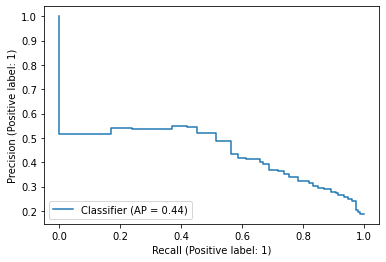

In [9]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_predictions(df_test[predictor_var],model.predict(df_test[features]))

In [10]:
precision, recall, pr_threshold = precision_recall_curve(df_test[predictor_var], model.predict(df_test[features]))

In [11]:
thres_pr_elbow = np.argmin([int(x > .4) for x in recall])

In [12]:
print(precision[thres_pr_elbow])
print(recall[thres_pr_elbow])
print(pr_threshold[thres_pr_elbow])

0.5366795366795367
0.3696808510638298
0.5100535


In [13]:
data_clicks_proba = data.copy()

In [14]:
model = models.Sequential()
model.add(layers.Dense(len(features), activation='relu', input_dim= len(features)))
model.add(layers.Dense(len(features), activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',
              metrics=[keras.metrics.AUC(curve = 'PR', name = 'AUCPR'), 
                       keras.metrics.AUC(name = 'AUCROC'),
                       keras.metrics.BinaryAccuracy()])


history = model.fit(df[features], 
                df[predictor_var],
                epochs = 200,
                batch_size = 1024)

Epoch 1/200
10/10 [==============================] - 0s 2ms/step - loss: 0.9260 - AUCPR: 0.3346 - AUCROC: 0.6969 - binary_accuracy: 0.1878
Epoch 2/200
10/10 [==============================] - 0s 2ms/step - loss: 0.8616 - AUCPR: 0.3549 - AUCROC: 0.7069 - binary_accuracy: 0.1878
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 0.8193 - AUCPR: 0.3593 - AUCROC: 0.7113 - binary_accuracy: 0.1878
Epoch 4/200
10/10 [==============================] - 0s 2ms/step - loss: 0.7855 - AUCPR: 0.3605 - AUCROC: 0.7179 - binary_accuracy: 0.1878
Epoch 5/200
10/10 [==============================] - 0s 2ms/step - loss: 0.7576 - AUCPR: 0.3629 - AUCROC: 0.7202 - binary_accuracy: 0.1878
Epoch 6/200
10/10 [==============================] - 0s 2ms/step - loss: 0.7337 - AUCPR: 0.3672 - AUCROC: 0.7209 - binary_accuracy: 0.1878
Epoch 7/200
10/10 [==============================] - 0s 2ms/step - loss: 0.7128 - AUCPR: 0.3707 - AUCROC: 0.7235 - binary_accuracy: 0.2588
Epoch 8/200
10/10 [========

10/10 [==============================] - 0s 2ms/step - loss: 0.3937 - AUCPR: 0.4465 - AUCROC: 0.7948 - binary_accuracy: 0.8180
Epoch 60/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3934 - AUCPR: 0.4444 - AUCROC: 0.7955 - binary_accuracy: 0.8192
Epoch 61/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3933 - AUCPR: 0.4455 - AUCROC: 0.7953 - binary_accuracy: 0.8179
Epoch 62/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3930 - AUCPR: 0.4461 - AUCROC: 0.7957 - binary_accuracy: 0.8192
Epoch 63/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3929 - AUCPR: 0.4418 - AUCROC: 0.7954 - binary_accuracy: 0.8181
Epoch 64/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3928 - AUCPR: 0.4454 - AUCROC: 0.7952 - binary_accuracy: 0.8191
Epoch 65/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3926 - AUCPR: 0.4440 - AUCROC: 0.7955 - binary_accuracy: 0.8192
Epoch 66/200
10/10 [=============

10/10 [==============================] - 0s 2ms/step - loss: 0.3906 - AUCPR: 0.4495 - AUCROC: 0.7958 - binary_accuracy: 0.8195
Epoch 118/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3906 - AUCPR: 0.4509 - AUCROC: 0.7962 - binary_accuracy: 0.8198
Epoch 119/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3906 - AUCPR: 0.4496 - AUCROC: 0.7962 - binary_accuracy: 0.8200
Epoch 120/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - AUCPR: 0.4466 - AUCROC: 0.7960 - binary_accuracy: 0.8203
Epoch 121/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3907 - AUCPR: 0.4458 - AUCROC: 0.7958 - binary_accuracy: 0.8199
Epoch 122/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3907 - AUCPR: 0.4496 - AUCROC: 0.7961 - binary_accuracy: 0.8216
Epoch 123/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - AUCPR: 0.4413 - AUCROC: 0.7960 - binary_accuracy: 0.8203
Epoch 124/200
10/10 [======

10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - AUCPR: 0.4510 - AUCROC: 0.7957 - binary_accuracy: 0.8203
Epoch 176/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - AUCPR: 0.4496 - AUCROC: 0.7958 - binary_accuracy: 0.8185
Epoch 177/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - AUCPR: 0.4495 - AUCROC: 0.7955 - binary_accuracy: 0.8204
Epoch 178/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3905 - AUCPR: 0.4510 - AUCROC: 0.7963 - binary_accuracy: 0.8196
Epoch 179/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3904 - AUCPR: 0.4518 - AUCROC: 0.7967 - binary_accuracy: 0.8192
Epoch 180/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3906 - AUCPR: 0.4477 - AUCROC: 0.7957 - binary_accuracy: 0.8180
Epoch 181/200
10/10 [==============================] - 0s 2ms/step - loss: 0.3904 - AUCPR: 0.4481 - AUCROC: 0.7971 - binary_accuracy: 0.8201
Epoch 182/200
10/10 [======

In [15]:
data_clicks_proba["click"] = model.predict(df[features])

In [16]:
data_clicks_proba.to_csv('data_click_probability.csv', index=False)

In [17]:
unique_data_clicks_proba = data_clicks_proba.drop_duplicates(subset = ["Currently Insured",
                                                                       "Number of Vehicles",
                                                                       "Number of Drivers",
                                                                       "Marital Status", 
                                                                       "rank"])

In [18]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [19]:
unique_data_clicks_proba.sort_values(by=['click'], ascending = False)

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click,policies_sold
309,Y,1,2,M,10,1,0.544504,0
183,Y,1,1,S,10,1,0.544504,0
78,Y,1,2,S,10,1,0.544504,0
9,unknown,1,2,M,10,1,0.531215,0
40,unknown,1,2,S,10,1,0.531215,1
156,unknown,1,1,S,10,1,0.531215,1
113,unknown,1,1,M,10,1,0.531215,0
58,unknown,2,2,M,10,1,0.516352,0
44,unknown,2,1,S,10,1,0.516352,0
34,unknown,2,2,S,10,1,0.516352,0


In [25]:
insured = ["unknown", "Y", "N"]
vehicles = [1, 2, 3]
drivers = [1, 2]
marry = ["M", "S"]
bid = [10]
rank = [1,2,3,4,5]

In [38]:
pre_df = []
for x in insured:
    for y in vehicles:
        for z in drivers:
            for u in marry:
                for v in rank:
                    temp = {}
                    temp["Currently Insured"] = x
                    temp["Number of Vehicles"] = y
                    temp["Number of Drivers"] = z
                    temp["Marital Status"] = u
                    temp["bid"] = 10
                    temp["rank"] = v
                    pre_df.append(temp)
all_data = pd.DataFrame(pre_df)

In [39]:
import category_encoders as ce

one_hot_cols = ["Currently Insured", "Marital Status"]
drop_cols = ["Currently Insured_unknown", "Marital Status_S"]
column_names = ['Currently Insured_Y', 'Currently Insured_N', 'Number of Vehicles','Number of Drivers',
                'Marital Status_M', 'bid', 'rank']
encoder = ce.OneHotEncoder(cols = one_hot_cols, use_cat_names = True)
temp = encoder.fit_transform(all_data)
temp = temp.drop(columns = drop_cols)
all_data_prep = temp.reindex(columns=column_names)

all_data["click"] = model.predict(all_data_prep[features])

C:\Users\David\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [40]:
all_data

,Currently Insured,Number of Vehicles,Number of Drivers,Marital Status,bid,rank,click
0,unknown,1,1,M,10,1,0.531215
1,unknown,1,1,M,10,2,0.316863
2,unknown,1,1,M,10,3,0.159565
3,unknown,1,1,M,10,4,0.072110
4,unknown,1,1,M,10,5,0.030830
5,unknown,1,1,S,10,1,0.531215
6,unknown,1,1,S,10,2,0.316863
7,unknown,1,1,S,10,3,0.159565
8,unknown,1,1,S,10,4,0.072110
9,unknown,1,1,S,10,5,0.030830


In [41]:
all_data.to_pickle("click_proba_df.pkl")